In [319]:
# Stylianos Topalidis
# AEM: 9613
# email: styltopa@ece.auth.gr 

In [1]:
# Note: Please run the cells sequentially as some of them
# require the execution of previous ones to run as expected

# Libraries imports
import numpy as np
import matplotlib.pyplot as plt
import random 

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# if the import below does not work please try opening a terminal and writing 
# pip install -U scikit-learn --user
# This worked for me (at least in vscode).
# There is some discourse in the forum that it does not work in collab
# see https://stackoverflow.com/questions/72246343/importerror-cannot-import-name-decisionboundarydisplay-from-sklearn-inspecti
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score

# Print the cell outputs
import tabulate
from IPython.display import HTML, display



# Part A

# Load data
iris = load_iris()

# Percentage of the data for the training 
trainPercent = 0.5

# Exclude duplicates of target values using set (multiple 0, 1 and 2)
# Turn the set into a list and then into a numpy array
# for convenience 
targetArr = np.array(list(set(iris.target)))


# - indsPerKind: Indexes per flower kind in iris.data (iterates over the
#  different targets: setosa, versicolor, virginica) 
# - trainingInds, testingInds: Indexes for the training and
#  testing data in the original dataset. 
indsPerKind = []
trainingInds = []
testingInds = []

# For each flower kind
for targetCount in range(len(targetArr)):

    # Only the first element of the returned array is the actual indexes  
    indsPerKind = list(np.where(iris.target == targetCount)[0]) 
    
    # number of training data derived from the training percentage selected
    # per group kind (0, 1, 2)
    numOfTrainingDataPerKind = round(trainPercent*len(indsPerKind))
    numOfTestingDataPerKind = len(indsPerKind) - numOfTrainingDataPerKind

    # Concatenate the indexes of the new target (kind) training data 
    # with the indexes of the old target training data
    trainingInds = trainingInds + indsPerKind[0:numOfTrainingDataPerKind]
    testingInds = testingInds + indsPerKind[numOfTrainingDataPerKind:]
    

# list -> np.array
trainingInds = np.array(trainingInds)
testingInds = np.array(testingInds)


# rnd: A seed used for the permutation of the training data
# and also for the classifiers themselves as the "random_state" parameter
# for both the DecisionTreeClassifier and the RandomForestClassifier

# For yielding different results with each execution
# randStart = 0
# randStop = 10000
# rnd  = np.random.randint(randStart, randStop)

# For replication
rnd = 0
np.random.seed(rnd)

# To avoid training the tree with batches of data of the same target,
# as given (all setosa first, then all versicolor and finally all virginica),
# we permute the training data .
trainingIndsPerm =  np.random.permutation(trainingInds)


# Training data and target values
trainingArr = iris.data[trainingIndsPerm, 0:2]
targetArrTraining = iris.target[trainingIndsPerm]

# Testing data and target values
testingArr = iris.data[testingInds, 0:2]
targetArrTesting = iris.target[testingInds]

# List with the accuracies of all decision tree classifiers per depth of tree
accList = list()

numOfTrainingData = len(targetArr)*numOfTrainingDataPerKind


# A.1

print('Decision Tree Classifier')

# Different depths of the decision tree classifier
treeDepths = np.array([1, 2, 3, 4, 5, 6])

# Train classifier per depth
for depthCount, depth in enumerate(treeDepths):
    # Classifier training
    clf = DecisionTreeClassifier(max_depth=depth, random_state = rnd)
    clf = clf.fit(trainingArr, targetArrTraining)
    
    # Classifier predictions of the targets
    targetArrPred = clf.predict(testingArr)

    accuracy = accuracy_score(targetArrTesting, targetArrPred)
    accList.append([str(depth), str(round(100*accuracy, 1))])

    # Find the classifier with the best accuracy to plot in part A.2
    if depth == treeDepths[0]:
        maxAccClf = clf
        maxAcc = accuracy
    if maxAcc < accuracy:
        maxAccClf = clf
        maxAcc = accuracy

print('----------------------------------'
    '\nMax accuracy classifier is the one with depth = ',
    maxAccClf.tree_.max_depth, 
    'and accuracy: ', round(100*maxAcc, 2), '%')


# Plot the accuracies of the classifiers per tree depth
table = tabulate.tabulate(accList, tablefmt='html', 
    headers=["Decision Tree depth", "Accuracy (%)"])
display(HTML(table))

# Remarks:
# 1) Randomness of the training:
# If the parameter "random_state" of the decision tree classifier object is not
# explicitly specified, the classifier derived from
# the training is different for consecutive trainings.
# 
# For convenience of the analysis we set the random_state parameter equal to
# a fixed value (0 in my case).
# Unless this is a fixed value, the classifier derived is different for consecutive 
# executions, 
# and so are different the the depth giving the best accuracy and the accuracy itself.
# Therefore, all remarks and points made from now on are based on the fact that
# random_state = 0. For different random_state values, the results differ.


# 2)
# The percentage of correct predictions in the testing set
# will be referred to as accuracy.
# The highest accuracy achieved is 80% (see cell output).
# The depth of the decision tree classifier giving the highest
# accuracy is 4 (see cell output).


Decision Tree Classifier
----------------------------------
Max accuracy classifier is the one with depth =  4 and accuracy:  80.0 %


Decision Tree depth,Accuracy (%)
1,64
2,68
3,69.3
4,80
5,80
6,80


In [17]:
# A.2
# Plot the decision boundaries of the classifier with the best accuracy
# found from A.1

stdVal = np.zeros((2,))
minBound = np.zeros((2,))
maxBound = np.zeros((2,))
numOfPointsInMesh = 100
space = np.zeros((numOfPointsInMesh, 2))

# bounds for the meshgrid
# coord = 0 for length and = 1 for width
for coord in range(0, 2):
    stdVal[coord] = np.std(iris.data[:, coord])
    minBound[coord] = np.min(iris.data[:, coord]) - stdVal[coord]/2
    maxBound[coord] = np.max(iris.data[:, coord]) + stdVal[coord]/2
    space[:, coord] = np.linspace(minBound[coord], maxBound[coord], numOfPointsInMesh)

# X is the sepal length and Y the sepal width space
X, Y = np.meshgrid(space[:, 0], space[:, 1])

Z = np.zeros_like(X)


for y in range(numOfPointsInMesh):
    valToPredict = np.stack((X[:, y], Y[:, y]), axis = 1)
    Z[:, y] = maxAccClf.predict(valToPredict)

fig, ax = plt.subplots()
c  = ['blue', 'grey', 'yellow'] 
CS = ax.contourf(X, Y, Z, cmap=plt.cm.cividis)

# Multiple scatter diagrams, one per kind of flower
for i, t in enumerate(targetArr):
    targetInds = np.where(targetArrTesting == t)
    plt.scatter(
        testingArr[targetInds, 0], testingArr[targetInds, 1], color = c[i],
        edgecolor="black", label =  iris.target_names[i] 
    )

plt.legend()

# Remarks
# 1) 
# The decision boundaries derived from the simple decision tree classifier
# are crisp and not complex (see cell output).

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1134, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 311, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "C:\Users\stelt\AppData\Roaming\Python\Python39\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2062, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "C:\Users\stelt\AppData\Roaming\Python\Python39\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2098, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [322]:
# Part B
# B.1


# Remarks
# 1) The accuracy percentage of the random forest classifier is 76% (see cell output).
# 2) The maximum tree depth of the forest guving the score above is
# equal to 2 (see cell output).

# 3) Randomness of the training

# - For different executions of the program, the accuracy percentage is 
# somewhere in the interval [76%, 81.33%]
# and the max depth of the trees in the forest giving the best accuracy
# is mostly 1, 2 or 3.


# - In the analysis in the last cell (you can uncomment the section -the code takes up 
# to a minute to run-), the bar graph shows that, for different seeds per training,
# the best accuracy is given in most cases (~50%) for max depths of the trees in the
# forest equal to 1, 2 or 3 in the majority of cases.


Random Forest Classifier
------------------------------------
Max accuracy classifier is the one with max tree depth =  2 and accuracy:  76.0 %


Decision Tree depth,Accuracy (%)
1,74.7
2,76
3,74.7
4,73.3
5,73.3
6,69.3


Text(0, 0.5, 'Accuracy (%)')

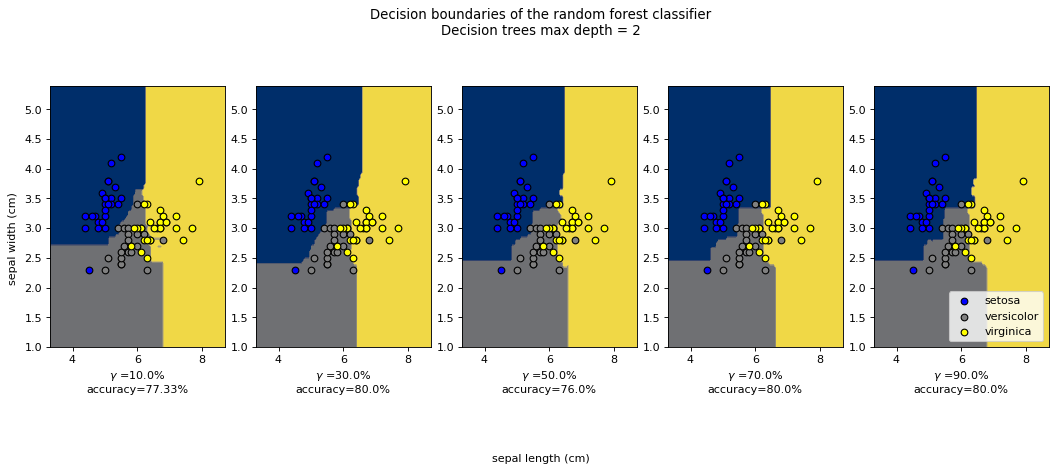

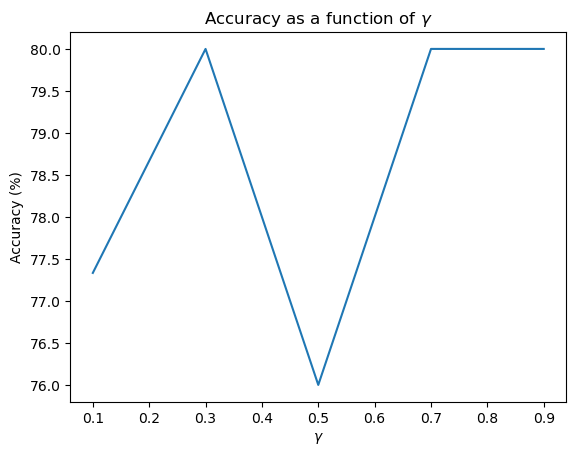

In [323]:
# B.2 

# # This line makes the random_state parameter 
# # of the classifier different in each execution
# # making it so the accuracy - gamma plot is different in each 
# # execution of the cell. 
# rnd = np.random.randint(0, 100000)


# Plot the decision boundaries of the classifiers for different percentage of
# the training data
fig = plt.figure(figsize=(15, 6), dpi=80)

# Set common labels for the plots in the figure
fig.text(0.5, 0.04, iris.feature_names[0], ha='center', va='center')
fig.text(0.06, 0.5, iris.feature_names[1], ha='center', va='center', rotation='vertical')

# The different percentages of the original training data to plot the 
# decision bounds for
gammaArr = [0.1, 0.3, 0.5, 0.7, 0.9]

accListPerGamma = []

for gammaCount, gammaVal in enumerate(gammaArr):
    
    # Different percentage (gamma) of the original training data is used each time
    bootSamNumOfElem = round(gammaVal*numOfTrainingData)

    
    # Training for the different gamma values and for the maxAccDepth found before
    clf = RandomForestClassifier(n_estimators=B, max_depth=maxAccDepth, 
        bootstrap=True, max_samples=bootSamNumOfElem, random_state=rnd)
    clf = clf.fit(trainingArr, targetArrTraining)

    # Classifier predictions of the targets
    targetArrPred = clf.predict(testingArr)

    # Accuracy
    accuracy = accuracy_score(targetArrTesting, targetArrPred)

    accListPerGamma.append(accuracy)

    # Plot a subplot for each gamma value
    ax = plt.subplot(1, len(gammaArr), gammaCount+1)        
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=7.5)
    decisionBoundDisp = DecisionBoundaryDisplay.from_estimator(
        clf, trainingArr,  cmap=plt.cm.cividis, response_method="predict",
        ax = ax,
        xlabel=r'$\gamma$ ='+ str(100*gammaVal)+ '%\naccuracy='+ str(round(100*accuracy, 2))+ '%',
        plot_method= 'contourf'
    )

    c  = ['blue', 'grey', 'yellow']

    for counter, target in enumerate(targetArr):
        targetInds = np.where(targetArrTesting == target)
        plt.scatter(
            testingArr[targetInds, 0], testingArr[targetInds, 1], color=c[counter], edgecolor="black", 
            label = iris.target_names[counter]
        )


plt.suptitle('Decision boundaries of the random forest classifier\nDecision trees max depth = ' \
        + str(maxAccDepth))
plt.legend(loc='lower right')

# Remarks
# 1) In comparison to the simple decision tree classifier, 
# the random forest one seems to catch the data patterns in more detail.
# The decision boundaries are more complex and not as crisp and defined as in the 
# decision tree classifier.

# B.3
# Remarks
# 1) 
# The percentage of the training data (gamma) used for the bootstrap samples of 
# the individual decision trees in
# the forest, seems to change the accuracy of the final model.
# For random_state of the classfiers = 0, as gamma is not a monotonous function of gamma.
# For other values of the random seed however, the accuracy of the algorithm
# seems to decrease with gamma.
# This is to be expected, as random forests exploit the idea that
# small subsamples of the original data (small values of gamma) contain
# classification information that is not visible when treating the data as a whole.
# Therefore, when gamma is small the classification tends to be more accurate. 
# This seems to be the advantage of random forests over a simple decision tree. 
# However, this is not the case for all values of the random_state parameter. 
# For some of them, the accuracy of the random forest classifier is larger than the one
# for the simple decision tree. For random_state = 0, the accuracy of the decision tree
# classifier is 80% and for the random forest on is 76%.

fig2, ax2 = plt.subplots()
plt.plot(gammaArr, np.array(accListPerGamma)*100)
ax2.set_title(r'Accuracy as a function of $\gamma$')
ax2.set_xlabel(r'$\gamma$')
ax2.set_ylabel('Accuracy (%)')

In [324]:
# # (Optional):  
# # For both parts A and part B above, the seed was set to 0 to make sure
# # we get the same classifier (same max depth of trees in the forest and
# # accuracy) each time the classifiers are trained.
# # The code below plots a bar graph of the max_depth of 
# # the random forest classifier for 20 repetitions of training
# # for random values in the random_state parameter.
# # This is a way to estimate the depth of the trees that give the best 
# # accuracy most of the times.
# # Disclaimer: The code of this cell takes about a minute to run



# # Number of bootstrap samples and number of trees in the random forest classifier
# B = 100
# # Percentage of the original training data in the bootstrap samples
# gamma = 0.5
# # Number of training data
# numOfTrainingData = len(targetArr)*numOfTrainingDataPerKind
# # Number of elements per bootstrap sample
# bootSamNumOfElem = round(gamma*numOfTrainingData)
# # The depths of the forests that give the best accuracy are stored here
# maxAccDepthList = []

# repetitions = 20
# # Train the random forest 20 times to find the 
# # depth of the trees giving the best classification accuracy
# for j in range(1, repetitions):    
#     # Forest tree depths
#     treeDepths = np.array([1, 2, 3, 4, 5, 6])
#     for depthCount in treeDepths:

#         # Classifier training        
#         # To yield different classifiers and so different depths that give the best
#         # accuracy with each execution, rnd is 
#         randStart = 0
#         randStop = 100000000
#         rnd  = np.random.randint(randStart, randStop)

#         clf = RandomForestClassifier(n_estimators=B, max_depth=depthCount, 
#             bootstrap=True, max_samples=bootSamNumOfElem, random_state=None)
#         clf = clf.fit(trainingArr, targetArrTraining)

#         # Classifier predictions of the targets
#         targetArrPred = clf.predict(testingArr)

#         # Accuracy 
#         accuracy = accuracy_score(targetArrTesting, targetArrPred)
#         if depthCount == treeDepths[0]:
#             maxAccClf = clf
#             maxAcc = accuracy
#             maxAccDepth = depthCount
#         if maxAcc < accuracy:
#             maxAccClf = clf
#             maxAcc = accuracy
#             maxAccDepth = depthCount
#     maxAccDepthList.append(maxAccDepth)

# fig, ax = plt.subplots()
# ax.set_title('Frequencies of the tree depths giving the maximum accuracy\nfor '
#     +str(repetitions) +' repetitions of the algorithm')
# ax.set_xlabel('Tree depths')
# ax.set_ylabel('Frequencies')

# # list with the frequencies of apperance
# frequencies = []

# for i in treeDepths:
#     frequencies.append(np.count_nonzero(maxAccDepthList==i))

# frequenciesArr = np.array(frequencies)

# labels = [str(i) for i in treeDepths]
# ax.bar(treeDepths, frequenciesArr, width = 0.5, label= len(labels) )

# # Remarks: most of the times, the classifier with the best accuracy 
# # is the one with small tree depth values (1, 2, 3) 